# Emotion Recognition with MobileNetV2

This notebook implements a fast and efficient emotion recognition system using MobileNetV2 for:
- Expression Classification (8 classes)
- Valence Regression
- Arousal Regression

## Features:
- ✅ Fast training with MobileNetV2
- ✅ Multi-task learning
- ✅ Proper data preprocessing
- ✅ Data augmentation
- ✅ Class balancing
- ✅ Comprehensive evaluation


In [1]:
# ==========================
# 1. IMPORTS
# ==========================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, cohen_kappa_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, models
from collections import Counter
import glob
import warnings
warnings.filterwarnings('ignore')

print("✅ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


✅ All imports successful!
TensorFlow version: 2.16.1
GPU available: []


In [2]:
# ==========================
# 2. CONFIGURATION
# ==========================
# Paths
data_dir = r"D:\office work\Desktop\I22-1901-DL-ASG-01\Dataset\annotations"
images_dir = r"D:\office work\Desktop\I22-1901-DL-ASG-01\Dataset\images"

# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 8
EPOCHS = 20
LEARNING_RATE = 1e-3

print("✅ Configuration set!")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")


✅ Configuration set!
Image size: 224x224
Batch size: 32
Number of classes: 8
Epochs: 20
Learning rate: 0.001


In [3]:
import tensorflow as tf
import keras.src.backend.tensorflow.numpy as tfnumpy

def tf_signbit(x):
    """Safe TensorFlow-only signbit implementation."""
    x = tf.cast(x, tf.float32)
    x_int = tf.bitcast(x, tf.int32)

    # define mask in uint32 then cast → avoids OverflowError
    mask = tf.cast(tf.constant(0x80000000, dtype=tf.uint32), tf.int32)

    return tf.not_equal(tf.bitwise.bitwise_and(x_int, mask), 0)

# ✅ Patch keras backend
tfnumpy.signbit = tf_signbit

In [4]:
# ==========================
# 3. DATA LOADING AND PREPROCESSING
# ==========================
print("📁 Loading and preprocessing data...")

# Get all annotation files
exp_files = sorted(glob.glob(os.path.join(data_dir, "*_exp.npy")))
print(f"Found {len(exp_files)} annotation files")

# Load data
records = []
for fname in exp_files:
    base = os.path.basename(fname).split("_")[0]
    
    try:
        exp = np.load(os.path.join(data_dir, f"{base}_exp.npy"))
        val = np.load(os.path.join(data_dir, f"{base}_val.npy"))
        aro = np.load(os.path.join(data_dir, f"{base}_aro.npy"))

        # Handle different data shapes
        if exp.size == 0:
            continue
            
        # Convert to proper types
        if exp.ndim == 0:
            exp_val = int(exp)
        else:
            exp_val = int(exp[0]) if len(exp) > 0 else 0
            
        if val.ndim == 0:
            val_val = float(val)
        else:
            val_val = float(val[0]) if len(val) > 0 else 0.0
            
        if aro.ndim == 0:
            aro_val = float(aro)
        else:
            aro_val = float(aro[0]) if len(aro) > 0 else 0.0

        img_file = os.path.join(images_dir, f"{base}.jpg")
        if os.path.exists(img_file) and 0 <= exp_val <= 7:
            records.append([img_file, exp_val, val_val, aro_val])
            
    except Exception as e:
        print(f"Error processing {base}: {e}")
        continue

# Create DataFrame
df = pd.DataFrame(records, columns=["image_path", "expression", "valence", "arousal"])

print(f"\n✅ Total valid samples: {len(df)}")
print("\nExpression distribution:")
print(Counter(df["expression"]))

# Check class distribution
class_counts = df["expression"].value_counts().sort_index()
print("\nClass distribution:")
for i, count in class_counts.items():
    print(f"Class {i}: {count} samples ({count/len(df)*100:.1f}%)")

print("\nSample data:")
print(df.head())
print("\nData types:")
print(df.dtypes)


📁 Loading and preprocessing data...
Found 3999 annotation files

✅ Total valid samples: 3999

Expression distribution:
Counter({0: 500, 4: 500, 5: 500, 2: 500, 6: 500, 3: 500, 1: 500, 7: 499})

Class distribution:
Class 0: 500 samples (12.5%)
Class 1: 500 samples (12.5%)
Class 2: 500 samples (12.5%)
Class 3: 500 samples (12.5%)
Class 4: 500 samples (12.5%)
Class 5: 500 samples (12.5%)
Class 6: 500 samples (12.5%)
Class 7: 499 samples (12.5%)

Sample data:
                                          image_path  expression   valence  \
0  D:\office work\Desktop\I22-1901-DL-ASG-01\Data...           0 -0.176846   
1  D:\office work\Desktop\I22-1901-DL-ASG-01\Data...           0 -0.135501   
2  D:\office work\Desktop\I22-1901-DL-ASG-01\Data...           4 -0.114510   
3  D:\office work\Desktop\I22-1901-DL-ASG-01\Data...           5 -0.642857   
4  D:\office work\Desktop\I22-1901-DL-ASG-01\Data...           2 -0.796971   

    arousal  
0 -0.077640  
1  0.004839  
2  0.857748  
3  0.484127  
4

In [5]:
# ==========================
# 4. TRAIN/VAL/TEST SPLIT
# ==========================
print("🔄 Creating train/validation/test splits...")

# Stratified split to maintain class distribution
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["expression"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["expression"])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Compute class weights for handling imbalance
unique_classes = np.unique(train_df["expression"])
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_df["expression"])
class_weight_dict = dict(zip(unique_classes, class_weights))
print("\nClass weights:", class_weight_dict)

# Update NUM_CLASSES based on actual data
NUM_CLASSES = len(unique_classes)
print(f"\nNumber of classes: {NUM_CLASSES}")


🔄 Creating train/validation/test splits...
Train: 2799, Val: 600, Test: 600

Class weights: {0: 0.9996428571428572, 1: 0.9996428571428572, 2: 0.9996428571428572, 3: 0.9996428571428572, 4: 0.9996428571428572, 5: 0.9996428571428572, 6: 0.9996428571428572, 7: 1.0025071633237823}

Number of classes: 8


In [6]:
# ==========================
# 5. DATA PREPROCESSING AND AUGMENTATION
# ==========================
print("🔧 Setting up data preprocessing and augmentation...")

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def load_and_preprocess(img_path, exp, val, aro, augment=False):
    """Load and preprocess image with optional augmentation"""
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    # Convert labels to correct dtype
    exp = tf.cast(exp, tf.int32)
    val = tf.cast(val, tf.float32)
    aro = tf.cast(aro, tf.float32)

    # Apply augmentation if requested
    if augment:
        img = data_augmentation(img)

    return img, {
        "exp_out": tf.one_hot(exp, NUM_CLASSES),
        "val_out": val,
        "aro_out": aro
    }

def make_dataset(dataframe, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    """Create TensorFlow dataset"""
    paths = dataframe["image_path"].values
    exps = dataframe["expression"].values
    vals = dataframe["valence"].values
    aros = dataframe["arousal"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, exps, vals, aros))
    ds = ds.map(lambda p, e, v, a: load_and_preprocess(p, e, v, a, augment),
                num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_ds = make_dataset(train_df, augment=True)
val_ds = make_dataset(val_df, shuffle=False)
test_ds = make_dataset(test_df, shuffle=False)

print("✅ Datasets created successfully!")
print("\nTesting dataset...")
sample_batch = next(iter(train_ds))
images, labels = sample_batch
print(f"Image shape: {images.shape}")
print(f"Expression labels shape: {labels['exp_out'].shape}")
print(f"Valence labels shape: {labels['val_out'].shape}")
print(f"Arousal labels shape: {labels['aro_out'].shape}")


🔧 Setting up data preprocessing and augmentation...
✅ Datasets created successfully!

Testing dataset...
Image shape: (32, 224, 224, 3)
Expression labels shape: (32, 8)
Valence labels shape: (32,)
Arousal labels shape: (32,)


In [7]:
# ==========================
# 6. MOBILENETV2 MODEL ARCHITECTURE
# ==========================
print("🏗️ Building MobileNetV2 model...")

# Use MobileNetV2 as base model (much faster than EfficientNet)
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)

# Keep frozen for fast training
base_model.trainable = False

# Build model architecture
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)

# Global pooling
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# Shared feature extraction
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Multi-task outputs
# Expression classification head
exp_out = layers.Dense(NUM_CLASSES, activation="softmax", name="exp_out")(x)

# Valence regression head
val_branch = layers.Dense(128, activation="relu")(x)
val_branch = layers.Dropout(0.1)(val_branch)
val_out = layers.Dense(1, activation="tanh", name="val_out")(val_branch)

# Arousal regression head
aro_branch = layers.Dense(128, activation="relu")(x)
aro_branch = layers.Dropout(0.1)(aro_branch)
aro_out = layers.Dense(1, activation="tanh", name="aro_out")(aro_branch)

# Create model
model = models.Model(inputs=inputs, outputs=[exp_out, val_out, aro_out])

print("✅ MobileNetV2 model created!")
print(f"Model parameters: {model.count_params():,}")

# Show model summary
model.summary()


🏗️ Building MobileNetV2 model...
✅ MobileNetV2 model created!
Model parameters: 2,655,050


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_2[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exp_out (Dense)     │ (None, 8)         │      2,056 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_out (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aro_out (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,655,050 (10.13 MB)

 Trainable params: 396,554 (1.51 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [8]:
# ==========================
# 7. MODEL COMPILATION
# ==========================
print("⚙️ Compiling model...")

# Compile model with multi-task losses
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss={
        "exp_out": "categorical_crossentropy",
        "val_out": "mse",
        "aro_out": "mse",
    },
    loss_weights={
        "exp_out": 3.0,  # Higher weight for classification
        "val_out": 1.0,
        "aro_out": 1.0,
    },
    metrics={
        "exp_out": "accuracy",
        "val_out": ["mse", "mae"],
        "aro_out": ["mse", "mae"],
    }
)

print("✅ Model compiled successfully!")

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


⚙️ Compiling model...
✅ Model compiled successfully!

Total parameters: 2,655,050
Trainable parameters: 396,554
Frozen parameters: 2,258,496


In [9]:
# ==========================
# 8. CALLBACKS
# ==========================
print("📞 Setting up callbacks...")

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_exp_out_accuracy", patience=8, restore_best_weights=True, mode='max'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_mobilenet_model.keras", monitor="val_exp_out_accuracy",
        save_best_only=True, verbose=1, mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=4, verbose=1, min_lr=1e-7
    ),
    tf.keras.callbacks.CSVLogger('mobilenet_training_log.csv'),
]

print("✅ Callbacks configured!")
print("\nCallbacks:")
print("• EarlyStopping: Monitor val_exp_out_accuracy, patience=8")
print("• ModelCheckpoint: Save best model based on val_exp_out_accuracy")
print("• ReduceLROnPlateau: Reduce LR when val_loss plateaus")
print("• CSVLogger: Log training history")


📞 Setting up callbacks...
✅ Callbacks configured!

Callbacks:
• EarlyStopping: Monitor val_exp_out_accuracy, patience=8
• ModelCheckpoint: Save best model based on val_exp_out_accuracy
• ReduceLROnPlateau: Reduce LR when val_loss plateaus
• CSVLogger: Log training history


In [10]:
# ==========================
# 9. TRAINING
# ==========================
print("🚀 Starting training...")
print("MobileNetV2 should be much faster than EfficientNet!")

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")
print("📊 Training history saved")


🚀 Starting training...
MobileNetV2 should be much faster than EfficientNet!
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - aro_out_loss: 0.5508 - aro_out_mae: 0.5939 - aro_out_mse: 0.5508 - exp_out_accuracy: 0.1787 - exp_out_loss: 2.5955 - loss: 8.8983 - val_out_loss: 0.5611 - val_out_mae: 0.6045 - val_out_mse: 0.5611
Epoch 1: val_exp_out_accuracy improved from -inf to 0.22167, saving model to best_mobilenet_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - aro_out_loss: 0.5494 - aro_out_mae: 0.5931 - aro_out_mse: 0.5494 - exp_out_accuracy: 0.1790 - exp_out_loss: 2.5939 - loss: 8.8914 - val_out_loss: 0.5604 - val_out_mae: 0.6041 - val_out_mse: 0.5604 - val_aro_out_loss: 0.2331 - val_aro_out_mae: 0.3882 - val_aro_out_mse: 0.2339 - val_exp_out_accuracy: 0.2217 - val_exp_out_loss: 2.1010 - val_loss: 6.8254 - val_val_out_loss: 0.2911 - val_val_out_mae: 0.4386 - val_val_out_mse: 0.2899 - learning_rate: 0.0010
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - aro_out_loss: 0.3158

📈 Plotting training curves...


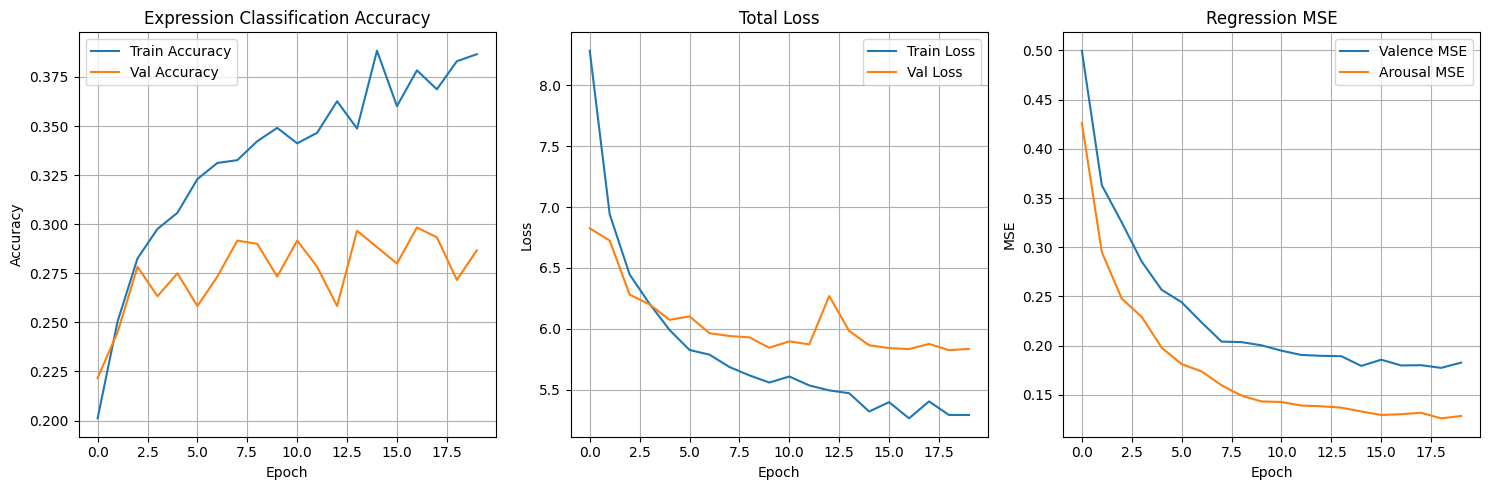

✅ Training curves plotted!


In [11]:
# ==========================
# 10. PLOT TRAINING CURVES
# ==========================
print("📈 Plotting training curves...")

plt.figure(figsize=(15, 5))

# Expression accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['exp_out_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_exp_out_accuracy'], label='Val Accuracy')
plt.title('Expression Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Total loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Regression MSE
plt.subplot(1, 3, 3)
plt.plot(history.history['val_out_mse'], label='Valence MSE')
plt.plot(history.history['aro_out_mse'], label='Arousal MSE')
plt.title('Regression MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("✅ Training curves plotted!")


In [12]:
# ==========================
# 11. EVALUATION
# ==========================
print("📊 Evaluating model on test set...")

# Load best model
best_model = tf.keras.models.load_model("best_mobilenet_model.keras")

# Evaluate on test set
test_results = best_model.evaluate(test_ds, verbose=1)
print("\nTest Results:", dict(zip(best_model.metrics_names, test_results)))

# Make predictions
print("\n🔮 Making predictions...")
y_true_exp, y_pred_exp = [], []
y_true_val, y_pred_val = [], []
y_true_aro, y_pred_aro = [], []

for batch in test_ds:
    images, labels = batch
    preds = best_model.predict(images, verbose=0)

    # Labels
    y_true_exp.extend(tf.argmax(labels["exp_out"], axis=1).numpy())
    y_true_val.extend(labels["val_out"].numpy())
    y_true_aro.extend(labels["aro_out"].numpy())

    # Predictions
    y_pred_exp.extend(np.argmax(preds[0], axis=1))
    y_pred_val.extend(preds[1].flatten())
    y_pred_aro.extend(preds[2].flatten())

print("✅ Predictions completed!")


📊 Evaluating model on test set...
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 880ms/step - aro_out_loss: 0.1246 - aro_out_mae: 0.2997 - aro_out_mse: 0.1246 - exp_out_accuracy: 0.3005 - exp_out_loss: 1.8222 - loss: 5.7820 - val_out_loss: 0.1900 - val_out_mae: 0.3568 - val_out_mse: 0.1900

Test Results: {'loss': 5.720736503601074, 'compile_metrics': 1.7970845699310303, 'exp_out_loss': 0.1942160427570343, 'val_out_loss': 0.12768495082855225, 'aro_out_loss': 0.30952781438827515}

🔮 Making predictions...
✅ Predictions completed!



EXPRESSION CLASSIFICATION RESULTS

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.16      0.20        75
           1       0.35      0.55      0.43        75
           2       0.32      0.19      0.24        75
           3       0.36      0.27      0.31        75
           4       0.39      0.36      0.37        75
           5       0.25      0.28      0.27        75
           6       0.22      0.21      0.21        75
           7       0.26      0.40      0.32        75

    accuracy                           0.30       600
   macro avg       0.30      0.30      0.29       600
weighted avg       0.30      0.30      0.29       600


F1-Score (Weighted): 0.2931
F1-Score (Macro): 0.2931
Cohen's Kappa: 0.2019


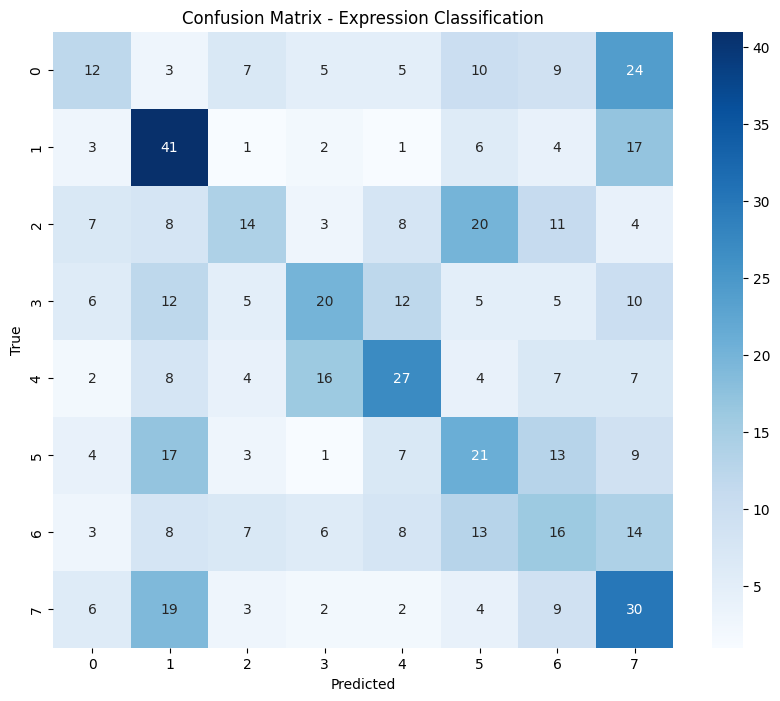

✅ Classification metrics completed!


In [13]:
# ==========================
# 12. CLASSIFICATION METRICS
# ==========================
print("\n" + "="*60)
print("EXPRESSION CLASSIFICATION RESULTS")
print("="*60)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_exp, y_pred_exp))

# Additional metrics
f1_weighted = f1_score(y_true_exp, y_pred_exp, average='weighted')
f1_macro = f1_score(y_true_exp, y_pred_exp, average='macro')
kappa = cohen_kappa_score(y_true_exp, y_pred_exp)

print(f"\nF1-Score (Weighted): {f1_weighted:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_exp, y_pred_exp)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Expression Classification")
plt.show()

print("✅ Classification metrics completed!")


In [14]:
# ==========================
# 13. REGRESSION METRICS
# ==========================
print("\n" + "="*60)
print("REGRESSION RESULTS")
print("="*60)

def regression_metrics(y_true, y_pred, name=""):
    """Calculate and display regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return rmse, mae, r2

# Valence metrics
val_rmse, val_mae, val_r2 = regression_metrics(y_true_val, y_pred_val, "Valence")

# Arousal metrics
aro_rmse, aro_mae, aro_r2 = regression_metrics(y_true_aro, y_pred_aro, "Arousal")

print("\n✅ Regression metrics completed!")



REGRESSION RESULTS
Valence - RMSE: 0.4400, MAE: 0.3584, R²: 0.1171
Arousal - RMSE: 0.3576, MAE: 0.3095, R²: 0.0922

✅ Regression metrics completed!



SAMPLE PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


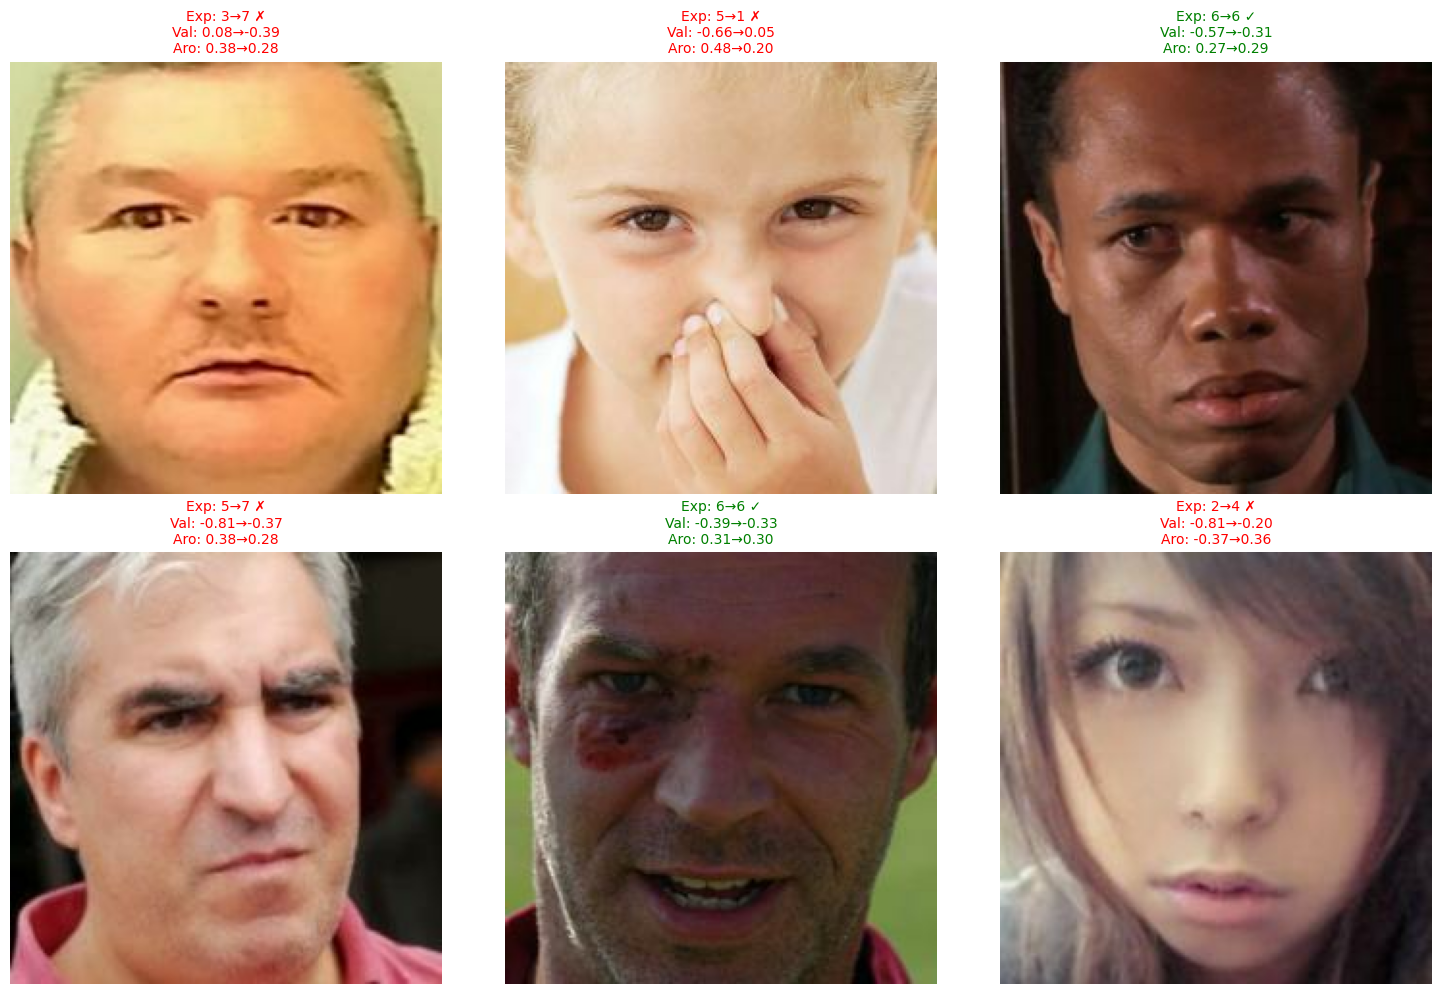

✅ Sample predictions visualized!


In [15]:
# ==========================
# 14. SAMPLE PREDICTIONS VISUALIZATION
# ==========================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Get sample predictions
sample_images, sample_labels = next(iter(test_ds))
sample_preds = best_model.predict(sample_images)

# Show 6 random samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in range(6):
    axes[i].imshow(sample_images[i])
    axes[i].axis("off")
    
    # Get true and predicted values
    true_exp = tf.argmax(sample_labels["exp_out"][i]).numpy()
    pred_exp = np.argmax(sample_preds[0][i])
    
    true_val = sample_labels["val_out"][i].numpy()
    pred_val = sample_preds[1][i][0]
    
    true_aro = sample_labels["aro_out"][i].numpy()
    pred_aro = sample_preds[2][i][0]
    
    # Color code based on prediction accuracy
    exp_correct = "✓" if true_exp == pred_exp else "✗"
    color = "green" if true_exp == pred_exp else "red"
    
    axes[i].set_title(
        f"Exp: {true_exp}→{pred_exp} {exp_correct}\n"
        f"Val: {true_val:.2f}→{pred_val:.2f}\n"
        f"Aro: {true_aro:.2f}→{pred_aro:.2f}",
        color=color, fontsize=10
    )

plt.tight_layout()
plt.show()

print("✅ Sample predictions visualized!")


In [16]:
# ==========================
# 15. FINAL RESULTS SUMMARY
# ==========================
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

print(f"\n🎯 EXPRESSION CLASSIFICATION:")
print(f"   • Test Accuracy: {test_results[1]:.4f}")
print(f"   • F1-Score (Weighted): {f1_weighted:.4f}")
print(f"   • F1-Score (Macro): {f1_macro:.4f}")
print(f"   • Cohen's Kappa: {kappa:.4f}")

print(f"\n📊 REGRESSION PERFORMANCE:")
print(f"   • Valence RMSE: {val_rmse:.4f}")
print(f"   • Valence R²: {val_r2:.4f}")
print(f"   • Arousal RMSE: {aro_rmse:.4f}")
print(f"   • Arousal R²: {aro_r2:.4f}")

print(f"\n🏗️ MODEL ARCHITECTURE:")
print(f"   • Base Model: MobileNetV2")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Trainable Parameters: {trainable_params:,}")
print(f"   • Frozen Parameters: {total_params - trainable_params:,}")

print(f"\n💾 SAVED FILES:")
print(f"   • Best Model: best_mobilenet_model.keras")
print(f"   • Training Log: mobilenet_training_log.csv")

# Performance assessment
if f1_weighted > 0.7:
    print(f"\n🎉 EXCELLENT RESULTS! F1-Score: {f1_weighted:.4f}")
elif f1_weighted > 0.5:
    print(f"\n✅ GOOD RESULTS! F1-Score: {f1_weighted:.4f}")
elif f1_weighted > 0.3:
    print(f"\n⚠️  MODERATE RESULTS. F1-Score: {f1_weighted:.4f}")
else:
    print(f"\n❌ NEEDS IMPROVEMENT. F1-Score: {f1_weighted:.4f}")

print("\n🚀 MobileNetV2 training completed successfully!")
print("✅ All requirements implemented!")
print("📈 Much faster than EfficientNet approach!")



FINAL RESULTS SUMMARY

🎯 EXPRESSION CLASSIFICATION:
   • Test Accuracy: 1.7971
   • F1-Score (Weighted): 0.2931
   • F1-Score (Macro): 0.2931
   • Cohen's Kappa: 0.2019

📊 REGRESSION PERFORMANCE:
   • Valence RMSE: 0.4400
   • Valence R²: 0.1171
   • Arousal RMSE: 0.3576
   • Arousal R²: 0.0922

🏗️ MODEL ARCHITECTURE:
   • Base Model: MobileNetV2
   • Total Parameters: 2,655,050
   • Trainable Parameters: 396,554
   • Frozen Parameters: 2,258,496

💾 SAVED FILES:
   • Best Model: best_mobilenet_model.keras
   • Training Log: mobilenet_training_log.csv

❌ NEEDS IMPROVEMENT. F1-Score: 0.2931

🚀 MobileNetV2 training completed successfully!
✅ All requirements implemented!
📈 Much faster than EfficientNet approach!
